## Modelo de Identificación de Alta Conductividad en Canal de Condensados PRE

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '5'

import numpy as np
import pandas as pd
import seaborn as sns
import funciones
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, silhouette_score

#### Carga del Dataset (Variables del Sistema de Control)

In [2]:
# Carga del Dataset
df_raw = pd.read_csv('Canal_Condensados_PRE.csv')

# Imputación de Medias por Día para Valores faltantes o con Error
df_raw = funciones.imputacion_media_dia(df_raw,False)

# Nombre de Variable Objetivo
canal = "Conductividad Canal Condensados PRE (uS)"

df_raw

,Dia Zafra,Nivel Vaso A1 (%),Nivel Vaso A1 (%) _STD,Nivel Vaso A2 (%),Nivel Vaso A2 (%) _STD,Nivel Vaso A3 (%),Nivel Vaso A3 (%) _STD,Nivel Vaso A4 (%),Nivel Vaso A4 (%) _STD,Nivel Vaso A5 (%),Nivel Vaso A5 (%) _STD,Nivel Vaso A6 (%),Nivel Vaso A6 (%) _STD,Nivel Vaso A7 (%),Nivel Vaso A7 (%) _STD,Nivel Vaso A8 (%),Nivel Vaso A8 (%) _STD,Nivel Vaso A9 (%),Nivel Vaso A9 (%) _STD,Conductividad Canal Condensados PRE (uS)
0,1.0,0.031247,0.007303,0.020857,0.005443,0.000000,0.000000,85.431509,0.192051,0.000000,0.000000,99.999985,0.000000,0.712131,0.217958,0.168999,0.141847,2.786714,0.012169,15.000000
1,1.0,0.032271,0.006998,0.021345,0.005411,0.000000,0.000000,85.448050,0.187367,0.000000,0.000000,99.999985,0.000000,0.695917,0.213642,0.189911,0.152112,2.788581,0.014473,15.000000
2,1.0,0.031505,0.006986,0.021262,0.005305,0.000000,0.000000,85.455451,0.184468,0.000000,0.000000,99.999985,0.000000,0.669772,0.221393,0.182132,0.143368,2.788278,0.014101,15.000000
3,1.0,0.030589,0.007123,0.021586,0.005954,0.000000,0.000000,85.444436,0.179097,0.000000,0.000000,99.999985,0.000000,0.678005,0.207590,0.175862,0.137858,2.785045,0.011671,15.000000
4,1.0,0.031497,0.007494,0.021146,0.005260,0.000000,0.000000,85.416842,0.183604,0.000009,0.000181,99.615126,0.710830,0.698450,0.218421,69.351309,42.327807,27.994591,40.620843,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,50.0,37.182920,13.437065,56.224971,2.362391,48.141849,2.762350,39.782778,1.307873,31.076178,2.120877,34.998127,4.270226,28.945617,2.761690,24.702373,2.529367,7.983522,25.147984,40.861548
1183,50.0,42.925893,2.268081,56.200794,3.066094,48.631729,3.899252,39.995591,0.412918,30.199167,1.503721,32.464125,4.199976,27.978978,3.518760,23.477413,2.422733,0.636667,0.012685,37.674048
1184,50.0,42.272657,0.983198,58.590219,2.241646,47.219586,3.054005,39.979806,0.341479,30.160907,0.501709,35.623855,1.824317,29.985877,0.434474,24.954949,1.418305,12.213477,25.441039,36.436757
1185,50.0,40.479558,2.140981,57.496650,2.226698,50.020351,2.553000,40.019065,0.379514,30.359847,1.968595,33.730622,3.898266,27.871952,3.499252,23.924261,2.748835,15.595673,24.984656,35.150443


### Tratamiento de Outliers y Distribución de Frecuencias de Valores de Conductividad

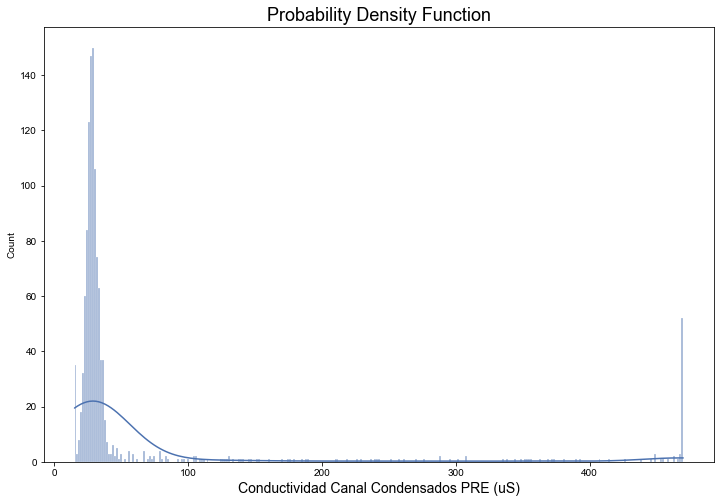

 Estadísticas de Conductividad: 


count    1187.000000
mean       65.822161
std       111.438589
min        15.000000
25%        26.130763
50%        29.048374
75%        33.935921
max       470.000000
Name: Conductividad Canal Condensados PRE (uS), dtype: float64

In [3]:
df = funciones.outliers(df_raw,canal,0)

### Determinación de Umbral Óptimo

Se aplica una **binarización** a la variable de conductividad. La binarización consiste en *transformar* la variable continua de conductividad a una variable binaria de *presencia* o *no presencia* de conductividad. Esto porque no toda conductividad se debe necesariamente a trazas de azúcar, y en la práctica es más útil definir un límite superior para esta variable. 

La binarización se implementa de forma que: Una **alta conductividad es una clase POSITIVA** y una **baja conductividad es una clase NEGATIVA**.

Adicionalmente, debido a la distribución *sesgada* de la variable de conductividad, es posible que una mala selección del umbral produzca un imbalance en el conjunto de entrenamiento y por lo tanto, métricas de detección del algoritmo que no son óptimas.

#### K-Means Clustering
Para poder distinguir entre clases, se ejecuta un algoritmo de clustering no-supervisado, con el propósito de encontrar **"regiones de operación"** en los datos, y luego verificar si estas regiones tienen en común algún rango de valores de conductividad.

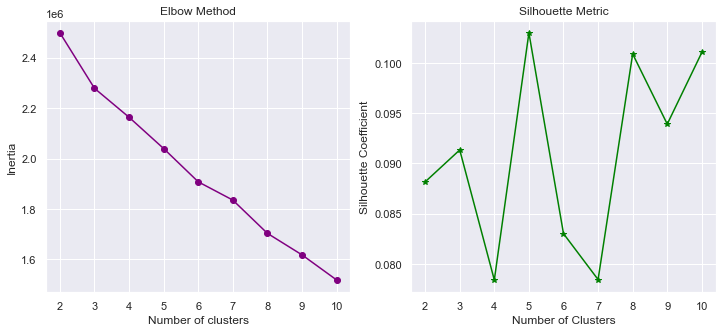

In [4]:
funciones.exploracion_clusters(df,canal)

Puede observarse que **las métricas de cohesión son más altas para 5 agrupaciones**. Se forman los 5 grupos utilizando el algoritmo K-Means, con n=5. Luego, se grafica la serie de tiempo de la conductividad durante la zafra y se colorean las regiones encontradas.

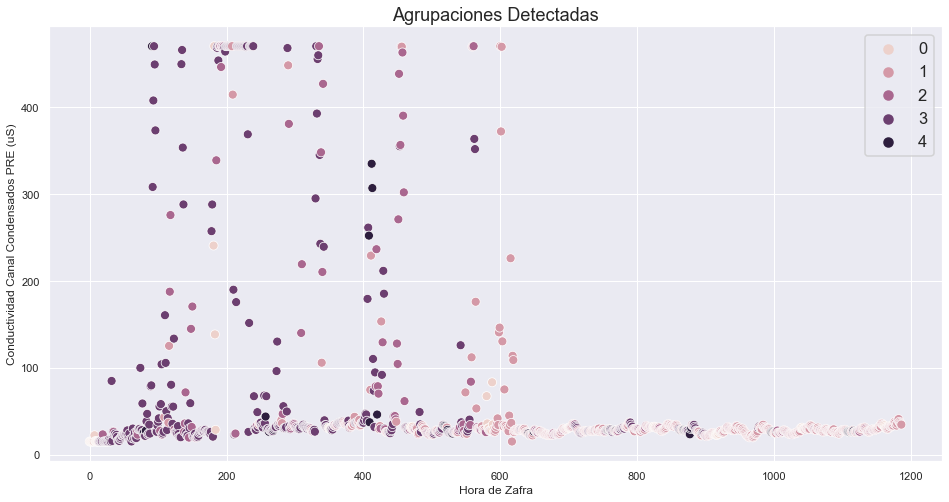

 Medias por Agrupación: 


,Dia Zafra,Nivel Vaso A1 (%),Nivel Vaso A1 (%) _STD,Nivel Vaso A2 (%),Nivel Vaso A2 (%) _STD,Nivel Vaso A3 (%),Nivel Vaso A3 (%) _STD,Nivel Vaso A4 (%),Nivel Vaso A4 (%) _STD,Nivel Vaso A5 (%),Nivel Vaso A5 (%) _STD,Nivel Vaso A6 (%),Nivel Vaso A6 (%) _STD,Nivel Vaso A7 (%),Nivel Vaso A7 (%) _STD,Nivel Vaso A8 (%),Nivel Vaso A8 (%) _STD,Nivel Vaso A9 (%),Nivel Vaso A9 (%) _STD,Conductividad Canal Condensados PRE (uS)
group,,,,,,,,,,,,,,,,,,,,
0,23.848485,27.017065,1.845956,32.513317,1.784013,31.289344,2.240499,48.586700,2.305008,21.286759,2.425219,76.686845,19.261708,18.512918,2.339746,33.298022,5.418331,32.851722,3.312695,46.094415
1,34.418112,33.660961,1.878370,43.466265,3.282376,43.396218,3.903160,41.889142,1.965438,29.541648,4.145660,24.648360,2.890012,25.840969,2.012905,27.022341,2.551209,28.342784,5.107162,39.969699
2,23.470588,38.484523,10.987562,37.394501,4.613918,39.439227,6.553914,39.938136,10.861947,30.222848,5.207725,27.973458,5.416527,22.918301,3.748317,34.529973,14.541636,29.186968,3.717694,82.922119
3,13.403101,26.622317,2.369314,23.901233,2.004173,25.761038,2.016944,28.581438,2.715133,24.094785,3.043413,21.479001,2.312167,18.822337,1.994667,21.245395,2.440173,21.904212,1.831784,97.461270
4,29.688889,30.645494,2.454957,32.615482,2.871028,39.278211,2.223860,36.662707,3.225675,24.667625,2.327027,24.119190,2.532687,43.682409,36.749254,24.172082,2.868815,26.515477,2.257110,56.225070


 Desviaciones Estándar por Agrupación: 


,Dia Zafra,Nivel Vaso A1 (%),Nivel Vaso A1 (%) _STD,Nivel Vaso A2 (%),Nivel Vaso A2 (%) _STD,Nivel Vaso A3 (%),Nivel Vaso A3 (%) _STD,Nivel Vaso A4 (%),Nivel Vaso A4 (%) _STD,Nivel Vaso A5 (%),Nivel Vaso A5 (%) _STD,Nivel Vaso A6 (%),Nivel Vaso A6 (%) _STD,Nivel Vaso A7 (%),Nivel Vaso A7 (%) _STD,Nivel Vaso A8 (%),Nivel Vaso A8 (%) _STD,Nivel Vaso A9 (%),Nivel Vaso A9 (%) _STD,Conductividad Canal Condensados PRE (uS)
group,,,,,,,,,,,,,,,,,,,,
0,16.208490,14.470902,2.209063,18.784967,2.177392,17.613124,2.612074,18.476680,2.396197,11.777345,2.372390,26.724733,18.587334,9.590996,1.704980,24.140007,6.538220,23.030120,7.788680,81.697272
1,10.294905,12.490847,2.457739,13.844672,7.056618,14.851770,7.996410,12.769495,1.947888,14.780049,8.916190,7.190887,4.625596,13.648273,1.385617,14.470506,3.013334,13.059588,10.054123,61.222147
2,12.295271,11.544089,11.303243,11.784002,5.156966,14.065182,8.025099,13.670174,12.001534,9.592082,5.959584,8.446275,5.243201,7.143165,3.289202,16.796493,13.885059,6.574431,4.151850,126.950880
3,9.797842,11.796045,2.990776,13.091102,3.795370,14.987870,2.950487,12.248810,3.735453,11.544077,5.728058,6.595835,2.755273,10.699059,2.611329,6.458512,2.737807,8.746125,3.057047,147.809798
4,13.431344,9.654075,3.643812,19.666907,4.821434,10.703320,1.697312,8.092018,6.028547,6.229941,1.850047,3.667487,1.798658,21.998349,6.415698,3.710205,2.451799,3.819721,3.008273,93.212512


In [5]:
funciones.clustering(df,canal,5)

Puede observarse que las agrupaciones 0 y 1 comparten tendencias de conductividad bajas. Existe un valor de aproximadamente 250 a 300 uS de conductividad en estas regiones estables.

Para explorar este umbral de conductividad, se implementa un algoritmo que explora *distintos umbrales de conductividad* y grafica las métricas de entrenamiento para cada selección:

- **Precision:** Habilidad de Clasificador de minimizar Falsos Positivos.
- **Accuracy:** Habilidad del Clasificador de Detectar Verdaderos Positivos y Verdaderos Negativos.
- **Recall:** Habilidad del Clasificador de Detectar Verdaderos Positivos.
- **F1:** Media Ponderada de la Precision y el Recall.
- **Overall:** Media Aritmética de todas las métricas anteriores.


De esta forma, se obtiene una **propuesta de umbral óptima**.

,Precision,Accuracy,F1,Recall,Overall
Umbral Conductividad,,,,,
20.0,0.963953,0.966387,0.982609,0.985465,0.974603
25.0,0.859664,0.876751,0.931889,0.983660,0.912991
40.0,0.791219,0.843137,0.151515,0.092593,0.469616
50.0,0.827185,0.868347,0.145455,0.085106,0.481523
60.0,0.828852,0.871148,0.115385,0.065217,0.470151


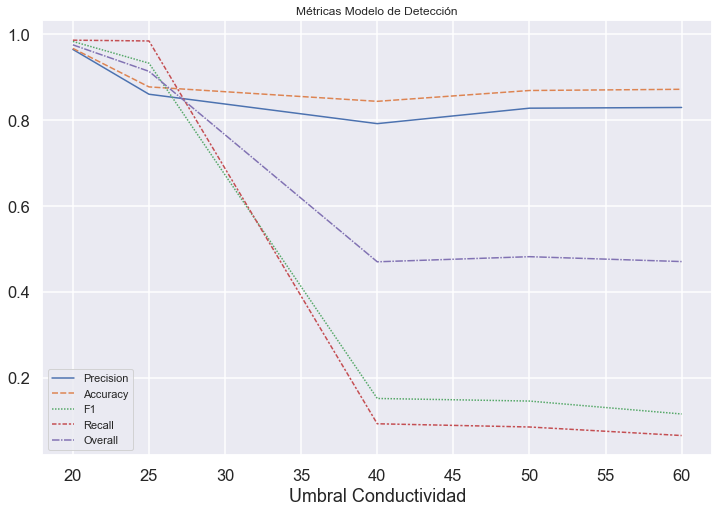

In [6]:
funciones.busqueda_umbral(df,canal,[20,25,40,50,60])

#### Selección de Umbral
El criterio para seleccionar el umbral se propone sea el del **"cima"**. En este método se selecciona un umbral a partir del cual las métricas caen por debajo de un nivel "aceptable".

Por ejemplo, una conductividad de 25 nos proporciona suficiente rango y además las métricas están arriba del 80%.


### Entrenamiento Modelo de Clasificación
Basado en los resultados anteriores, se selecciona un umbral y se entrena el modelo de detección.

In [7]:
# Umbral de Detección
umbral_final = 25

# Binarización y construcción del Dataset de Entrenamiento y Validación
X = df.drop(canal, axis=1)
y = df[canal].apply(lambda x: 1 if x > umbral_final else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456)

In [8]:
# Estandarización y Entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
coefficients = model.coef_[0]

### Métricas Finales de Entrenamiento y Matriz de Confusión
Se muestran las métricas del modelo final y su desempeño para detectar Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos y Falsos Negativos.

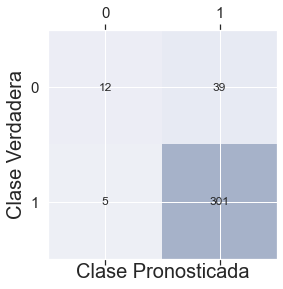

In [9]:
y_pred = model.predict(X_test_scaled)

conf_mat = funciones.matriz_confusion(y_test,y_pred)

In [10]:
funciones.metricas_finales(y_test,y_pred,umbral_final)

,Umbral Conductividad,Precision (%),Accuracy (%),F1 (%),Recall (%),Overall (%)
0,25.0,85.966387,87.67507,93.188854,98.366013,91.299081


### Factores de Importancia
Para la determinación de los factores de importancia se presentan dos perspectivas: Importancia por Magnitud del Factor e Importancia por Control del Factor.

#### Importancia por Magnitud del Factor
Esta importancia es el peso relativo que tiene este factor respecto a los demás factores, para contribuir positivamente o negativamente a la conductividad.
Si la contribución es positiva, a mayor magnitud del factor, mayor probabilidad de detectar la clase positiva (mayor probabilidad de alta conductividad).
Si la contribución es negativa, a mayor magnitud del factor, mayor probabilidad de detectar la clase negativa (menor probabilidad de alta conductividad).

#### Importancia por Control del Factor
Esta importancia se calcula a partir del efecto que tiene aleatorizar la variable (manteniendo todas las demás constantes) sobre la conductividad. Esto es especialmente importante para identificar **el efecto que tiene la precisión del control de la variable sobre la conductividad final**.

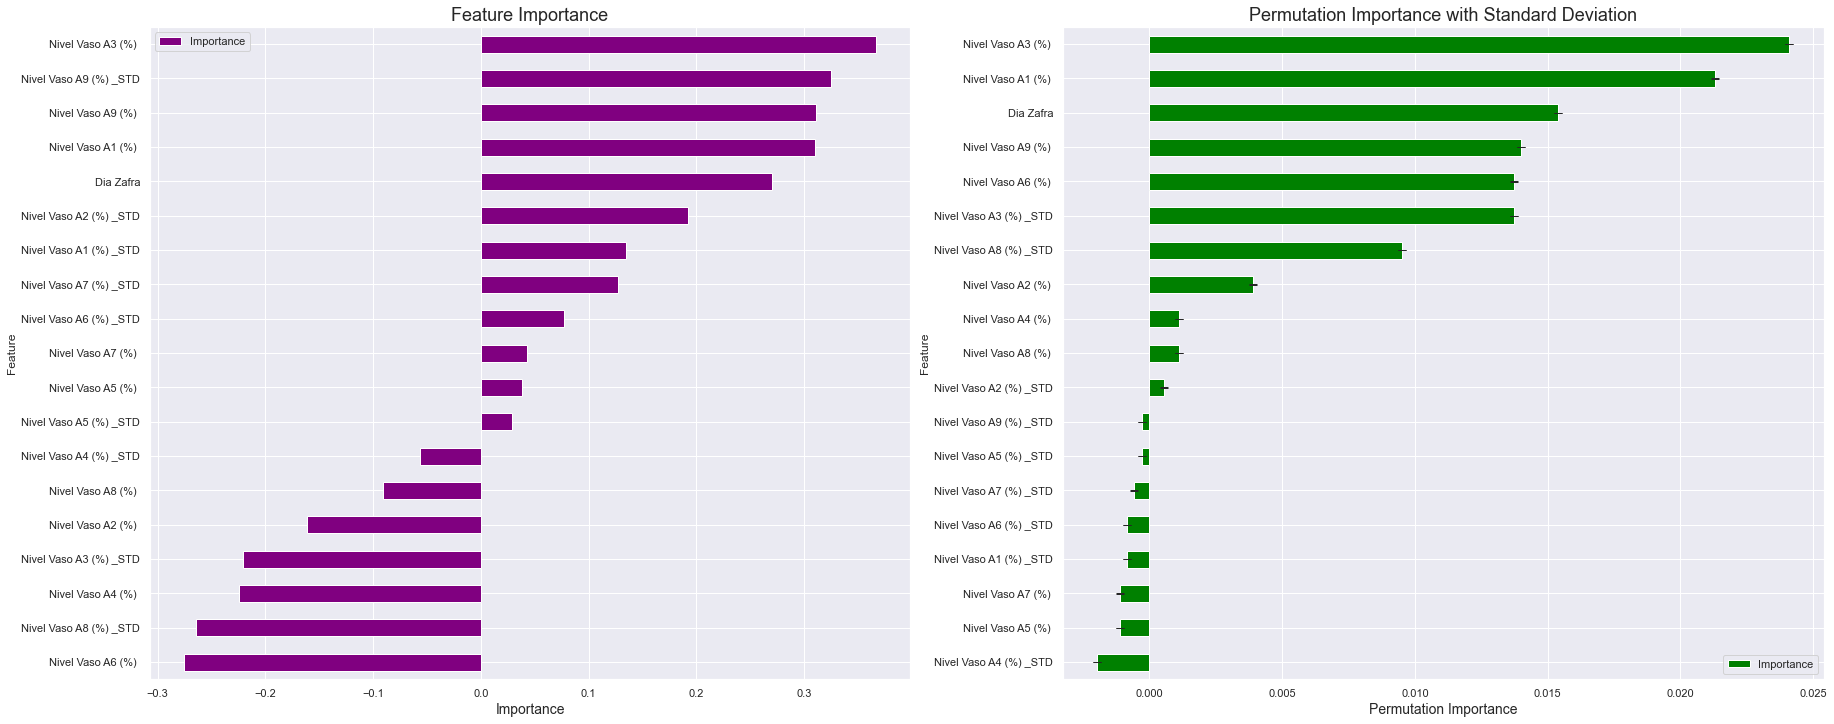

In [11]:
funciones.importancias_modelo(model,X,coefficients,X_test_scaled,y_test)

### Probabilidad de Clase Positiva (Alta Conductividad)
El modelo permite conocer cómo cada factor impacta la probabilidad de obtener la **clase positiva** (*alta conductividad*). 

Para ello se presentan los **incrementos en probabilidad**: *Si el factor tiene un incremento unitario, cuánto aumenta la probabilidad de tener una alta conductividad*.

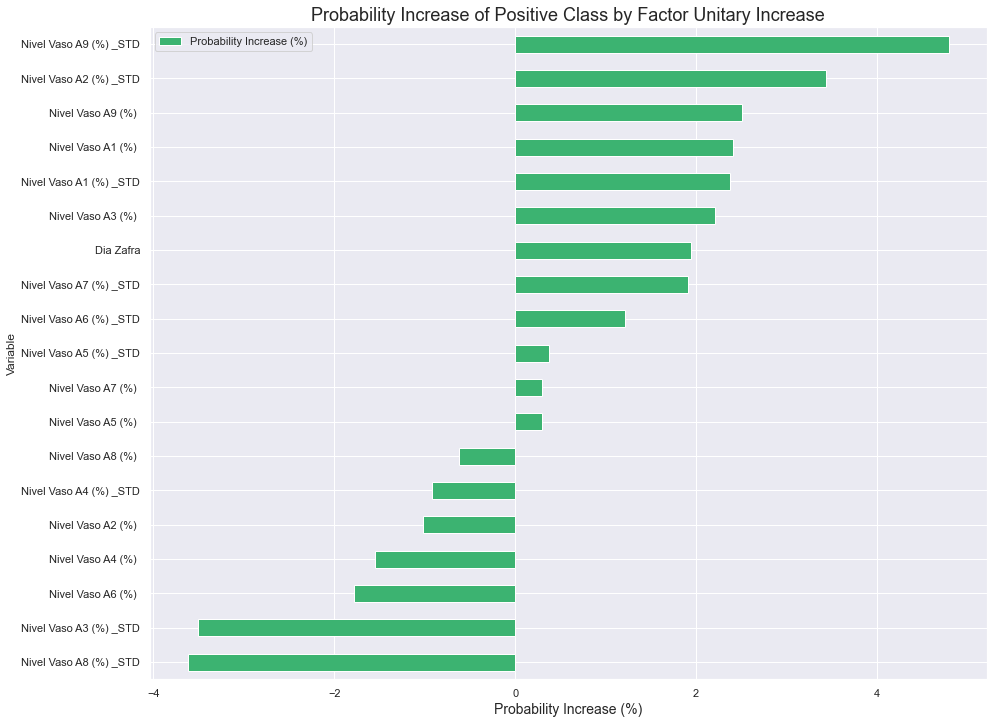

In [12]:
funciones.logprob(X,X_train,y_train)

### Conclusiones:
Dados los factores de importancia identificados, las recomendaciones son las siguientes:
- Para los **factores con mayor importancia por magnitud** se recomienda controlar con un **SP menor** (si la importancia por magnitud es **positiva**) o con un **SP mayor** (si la importancia por magnitud es **negativa**) para *reducir la probabilidad de tener alta conductividad*.
- Para conocer *qué tanto incrementar o decrementar el SP del factor*, se verifica su contribución a la **Probabilidad de Clase Positiva**: Si la contribución es positiva, se recomienda reducir el SP. Si la contribución es negativa, se recomienda aumentar el SP. Ambas acciones **reducirán la probabilidad de ocurrencia de la clase positiva** (alta conductividad).
- Para los **factores con mayor importancia por control** se recomienda **reducir la varianza de la variable** (reducir su variación si es posible por medios manuales o ajustes de los lazos de control involucrados). En el caso de *importancias negativas*, significa que los algoritmos *no encontraron evidencia de que el control de esta variable importe para la estabilidad de la conductividad*.